## Import Installations

In [ ]:
#pip install --upgrade jaxlib
!pip install jaxlib==0.4.23
!pip install jax==0.4.23

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.3
    Uninstalling jaxlib-0.5.3:
      Successfully uninstalled jaxlib-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optax 0.2.6 requires jaxlib>=0.5.3, but you have jaxlib 0.4.23 which is incompatible.
chex 0.1.90 requires jaxlib>=0.4.27, but you have jaxlib 0.4.23 which is incompatible.
jax 0.5.3 requires jaxlib<=0.5.3,>=0.5.3, but you have jaxlib 0.4.23 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.5.3
    Uninstalling jax-0.5.3:
      Successfully uninstalled jax-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

In [ ]:
pip install --upgrade e3nn-jax

In [ ]:
pip install --upgrade jax-md

In [ ]:
pip install sympy

In [ ]:
pip install scikit-image

In [ ]:
import jax.numpy as np
import numpy as onp
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from jax.nn import relu
from jax import jit
from jax import vmap, pmap
from jax import lax
from jax import random
from jax import grad, value_and_grad, hessian, jacfwd, jacrev, jvp

from jax_md import space
from jax_md import quantity
from jax_md.quantity import box_size_at_number_density

from jax.config import config
config.update('jax_enable_x64', True)

from sympy import symbols
from sympy.plotting import plot
from sympy import diff, tanh

from scipy.sparse import csgraph

from functools import partial

import math
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

<ipython-input-6-e0dc39ecfa68>:19: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [ ]:
from sympy import symbols
from sympy.plotting import plot
from sympy import diff, tanh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/generative_pattern_formation/spatial_transcriptomics/

/content/drive/MyDrive/generative_pattern_formation/spatial_transcriptomics


In [ ]:
ls

error.pdf                             traj_64_particles_counter1loop0.npy
traj_64_particles_counter0loop0.npy   traj_64_particles_counter1loop25.npy
traj_64_particles_counter0loop25.npy  traj_64_particles_counter1loop50.npy
traj_64_particles_counter0loop50.npy  traj_64_particles_counter1loop75.npy
traj_64_particles_counter0loop75.npy  traj_64_particles_counter2loop0.npy


##Predefined Functions

In [ ]:



def square_lattice(N, box_size):
  Nx = int(np.sqrt(N))
  Ny, ragged = divmod(N, Nx)
  if Ny != Nx or ragged:
    assert ValueError('Particle count should be a square. Found {}.'.format(N))
  length_scale = box_size / Nx
  R = []
  for i in range(Nx):
    for j in range(Ny):
      R.append([i * length_scale, j * length_scale])
  return np.array(R)



In [ ]:
displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

#Visualize Network

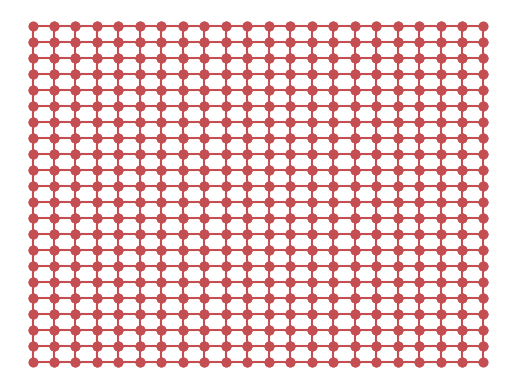

In [ ]:
fig, ax = plt.subplots()

X = np.array([R0[np.where(A)[0]], R0[np.where(A)[1]]])
ax.plot(X[:,:,0],X[:,:,1], 'ro-', zorder=1)
ax.axis('off')

plt.show()

Chemical Energy

In [ ]:
def chem_energy(C,A):
  dC = metric(C, C)
  return 0.5 * np.einsum('ij,ij->', A, np.square(dC))

##Terminal Cost

In [ ]:
def terminal_cost(C):
  return np.einsum('ij->', np.square(np.square(C) - 1))

##Control Hamiltonian

In [ ]:
def ctrl_hamiltonian(C,Lambda):
  gamma = 1e0
  return -(1/2*gamma)*np.einsum('ij,ij->', Lambda, Lambda)  - np.einsum('ij,ij->', jacrev(chem_energy, argnums=0)(C,A), Lambda)

##Forward-Backward Dynamics

In [ ]:
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt

def fwd_dyn(t, G, args):
  C, Lambda = G
  Cdot = jacrev(ctrl_hamiltonian, argnums=1)(C,Lambda)
  Lambdadot = -jacrev(ctrl_hamiltonian, argnums=0)(C,Lambda)
  F = [Cdot, Lambdadot]
  return F

def bwd_dyn(t, U, args):
  Cad, Lambdaad = U
  C, Lambda = args

  ind = 100-100*t-1
  ind = ind.astype(int)

  d2H_dC_dC = jacfwd(jacrev(ctrl_hamiltonian, argnums=0), argnums=0)(C[ind],Lambda[ind])
  d2H_dC_dLambda = jacfwd(jacrev(ctrl_hamiltonian, argnums=0), argnums=1)(C[ind],Lambda[ind])
  d2H_dLambda_dLambda = jacfwd(jacrev(ctrl_hamiltonian, argnums=1), argnums=1)(C[ind],Lambda[ind])

  Caddot = np.einsum('ij,ijkl', Cad, d2H_dC_dLambda )  - np.einsum('ij,ijkl', Lambdaad, d2H_dC_dC)
  Lambdaaddot = np.einsum('ij,ijkl', Cad, d2H_dLambda_dLambda )  - np.einsum('ij,ijkl', Lambdaad, d2H_dC_dLambda)
  V = [Caddot, Lambdaaddot]
  return V

##Solve

In [ ]:
C0 = C0
Lambda0 = 0.0*np.ones(C0.shape)

t0 = 0.0
t1 = 0.1

In [ ]:
for i in range(130):
  # solver = Dopri5()
  solver = Euler()
  stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

  # fwd_sol = diffeqsolve(ODETerm(fwd_dyn), solver, t0=t0, t1=t1, dt0=0.00001, y0=[np.float64(C0),np.float64(Lambda0)], saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)
  fwd_sol = diffeqsolve(ODETerm(fwd_dyn), solver, t0=t0, t1=t1, dt0=0.001, y0=[np.float64(C0),np.float64(Lambda0)], saveat=SaveAt(ts=np.linspace(t0,t1,100)), max_steps=None)


  args = fwd_sol.ys

  Cad0 = jacfwd(terminal_cost, argnums=0)(fwd_sol.ys[0][-1])
  Lambdaad0 = np.zeros(Lambda0.shape)

  print([i, np.sqrt(terminal_cost(fwd_sol.ys[0][-1]))])

  # bwd_sol = diffeqsolve(ODETerm(bwd_dyn), solver, t0=t0, t1=t1, dt0=0.00001, y0=[np.float64(Cad0),np.float64(Lambdaad0)], args=args, saveat=SaveAt(ts=np.linspace(t0,t1,1000)), stepsize_controller=stepsize_controller, max_steps=None)
  bwd_sol = diffeqsolve(ODETerm(bwd_dyn), solver, t0=t0, t1=t1, dt0=0.001, y0=[np.float64(Cad0),np.float64(Lambdaad0)], args=args, saveat=SaveAt(ts=np.linspace(t0,t1,100)), max_steps=None)

  key = random.PRNGKey(i)
  eta_learning = 1e1*random.uniform(key, minval=0.5, maxval=1.0)

  Lambda0 = Lambda0 - eta_learning*bwd_sol.ys[1][-1]

[0, Array(20.04406633, dtype=float64)]
[1, Array(19.98192231, dtype=float64)]
[2, Array(19.93127963, dtype=float64)]
[3, Array(19.88911807, dtype=float64)]
[4, Array(19.8154501, dtype=float64)]
[5, Array(19.71145664, dtype=float64)]
[6, Array(19.59525162, dtype=float64)]
[7, Array(19.31763623, dtype=float64)]
[8, Array(19.1037154, dtype=float64)]
[9, Array(18.66531644, dtype=float64)]
[10, Array(18.44819223, dtype=float64)]
[11, Array(18.24306201, dtype=float64)]
[12, Array(18.0775598, dtype=float64)]
[13, Array(18.03669456, dtype=float64)]
[14, Array(18.01421237, dtype=float64)]
[15, Array(17.98770638, dtype=float64)]
[16, Array(17.93796965, dtype=float64)]
[17, Array(17.8783901, dtype=float64)]
[18, Array(17.80704992, dtype=float64)]
[19, Array(17.63624635, dtype=float64)]
[20, Array(17.35116612, dtype=float64)]
[21, Array(16.98172875, dtype=float64)]
[22, Array(16.693417, dtype=float64)]
[23, Array(16.34538104, dtype=float64)]
[24, Array(16.0969884, dtype=float64)]
[25, Array(15.851

##Plot

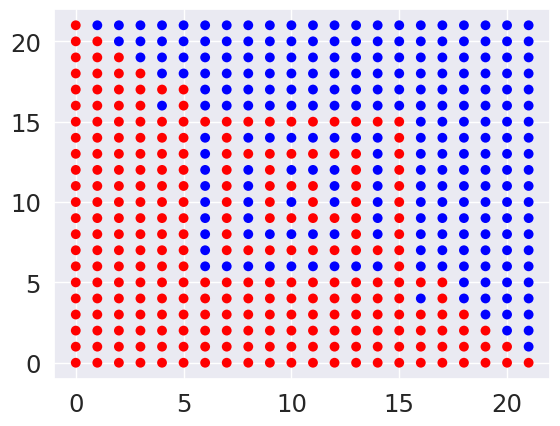

In [ ]:
C_data = fwd_sol.ys[0][-1]

col =[]
for i in range(N):
  a=np.abs(C_data[i]+1)
  b=np.abs(C_data[i])
  c=np.abs(C_data[i]-1)
  true_col= min([a,b,c])
  if(true_col==a):
    col.append('red')
  if(true_col==b):
    col.append('black')
  if(true_col==c):
    col.append('blue')
plt.scatter(R0[:,0], R0[:,1], c = col, s = 50,linewidth = 0)
plt.xlim((-1,np.max(R0[:,0]+1)))
plt.ylim((-1,np.max(R0[:,0]+1)))

plt.show()

##Animate

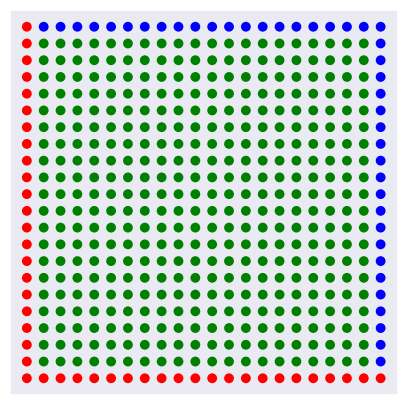

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(k):
  j=k

  ax.clear()
  col =[]

  for i in range(N):
    a=np.abs(fwd_sol.ys[0][j][i]+1)
    b=np.abs(fwd_sol.ys[0][j][i])
    c=np.abs(fwd_sol.ys[0][j][i]-1)
    true_col= min([a,b,c])
    if(true_col==a):
      col.append('red')
    if true_col==b:
      col.append('green')
    if true_col==c:
      col.append('blue')
  #for i in range(N):
  plot=ax.scatter(R0[:,0], R0[:,1], c = col, s = 50,linewidth = 0)
  plt.xlim((-1,np.max(R0[:,0]+1)))
  plt.ylim((-1,np.max(R0[:,0]+1)))
  plt.xticks([])
  plt.yticks([])

  #plt.show()


    #return bgrnd,fgrnd
  return plot

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=100)
ani.save("st_new.gif", dpi=300, writer=PillowWriter(fps=10))

#Stochastic Lagrangian Implementation

In [ ]:
N = 64
dim = 2

In [ ]:
box_size = box_size_at_number_density(particle_count = N, number_density = 1, spatial_dimension = dim)
R0 = square_lattice(N, box_size)
C0 = np.zeros((R0.shape[0],1))
C0 = C0.at[np.array(np.where((R0[:,0]==0) | (R0[:,1]==0)))].set(0)
C0 = C0.at[np.array(np.where((R0[:,0]==np.max(R0[:,0])) | (R0[:,1]==np.max(R0[:,1]))))].set(0)

In [ ]:
R0.shape

(64, 2)

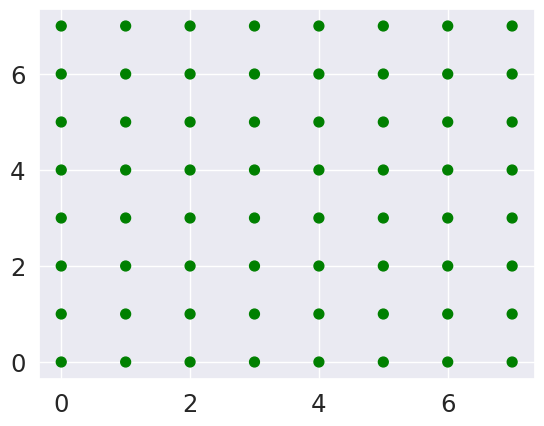

In [ ]:
c = ['red', 'green', 'blue']
plt.scatter(R0[:,0], R0[:,1], c = [c[i+1] for i in C0[:,0].astype(int)], s = 50)
plt.show()

In [ ]:
def chemo_mech_energy(Z):
  R = Z[0:N, :]
  C = Z[N:2*N, :]

  l1 = box_size/2
  l2 = box_size/10

  dr2 = np.square(metric(R, R))
  dc2 = np.square(metric(C, C))

  return 0.05*(np.sum(-np.exp(-dr2/(2*l1*l1))) + np.einsum('ij,ij->', dc2, np.exp(-dr2/(2*l2*l2))))

In [ ]:
Ck_array = np.array([[1.0], [-1.0]])
muk_array = np.array([[0.0, 7.0],[7.0, 0.0]])

In [ ]:
def terminal_cost(Z):
  R = Z[0:N,:]
  C = Z[N:2*N,:]

  delta_c = 1
  delta_mu = 1
  sigma = 1

  # Ck_array = np.array([[1.0], [-1.0]])
  # muk_array = np.array([[2.0, 2.0], [7.0, 7.0]])

  Cik_matrix = np.exp(-np.square(np.column_stack([C[:,0]- Ck_array[0],C[:,0]- Ck_array[1]]))/(2*sigma*sigma))
  Rik_matrix = np.column_stack([np.reshape(np.sum(np.square(R[:,:]- muk_array[0]),axis=1),(N,1)),np.reshape(np.sum(np.square(R[:,:]- muk_array[1]),axis=1),(N,1))])

  # first_term = (delta_c/4)*np.sum(np.square(np.square(C[:,0]) - 1))
  # second_term = (delta_mu/2)*np.einsum('ij,ij->',Cik_matrix,Rik_matrix)

  return (delta_c/4)*np.sum(np.square(np.square(C[:,0]) - 1)) + (delta_mu/2)*np.einsum('ij,ij->', Cik_matrix, Rik_matrix)

batch_terminal_cost = vmap(terminal_cost)

In [ ]:
C0_appended = np.append(C0, np.zeros(C0.shape), axis=1)
Z0 = np.vstack([R0,C0_appended])

In [ ]:
gamma = 1e0
D = 0.0005
beta = 1/(2*gamma*D)

In [ ]:
t0, t1 = 0, 1
dt0 = 0.01

n_steps = int((t1-t0)/dt0)
n_samples = 100

In [ ]:
def fwd_uncontrolled_dyn(t, Z, args):
  i, j = args

  ind = t/dt0
  ind = ind.astype(int)

  Zdot = - jacrev(chemo_mech_energy, argnums=0)(Z) + np.sqrt(2*D/dt0)*random.normal(random.PRNGKey(i*j*ind), shape=np.array(Z).shape)

  return Zdot

In [ ]:
def adj_dyn(t, Lambda, args):
  Z = args

  ind = (t1-t)/dt0
  ind = ind.astype(int)
  ind = ind - 1

  Lambdadot = np.einsum('ij,ijkl->kl', Lambda, jacfwd(jacrev(chemo_mech_energy, argnums=0), argnums=0)(Z[ind]))

  return Lambdadot

In [ ]:
def fwd_uncontrolled_dyn_solver(sample_id):
  return diffeqsolve(ODETerm(fwd_uncontrolled_dyn), Euler(), t0=t_present, t1=t1, dt0=dt0, y0=Z, args=[int((t_present - t0)/dt0), sample_id], saveat=saveat, max_steps=None)

batch_fwd_uncontrolled_dyn_solver = vmap(fwd_uncontrolled_dyn_solver)

In [ ]:
def adj_dyn_solver(boltzmann_fac, fwd_traj):
  return diffeqsolve(ODETerm(adj_dyn), Euler(), t0=t_present, t1=t1, dt0=dt0, y0=boltzmann_fac*jacfwd(terminal_cost)(fwd_traj[-1,:,:]), args=fwd_traj, saveat=saveat, max_steps=None)

batch_adj_dyn_solver = vmap(adj_dyn_solver)

In [ ]:
Z = Z0
traj = []
ctrl=[]

In [ ]:
sample_id = random.uniform(random.PRNGKey(0), shape=(n_samples,), minval=0, maxval=100)
sample_id = sample_id.astype(int)
counter=0

while(np.sqrt(terminal_cost(Z))>5.0):

  for i in range(int(t1/dt0)):
    traj.append(Z)
    if(i%25==0):
      np.save('traj_64_particles_counter'+str(counter)+'loop'+str(i), traj, allow_pickle=True)

    print(i, np.sqrt(terminal_cost(Z)))
    t_present = t0 + dt0*i
    saveat = SaveAt(ts=np.linspace(t_present,t1,int((t1-t_present)/dt0)))

    fwd_uncontrolled_sol = batch_fwd_uncontrolled_dyn_solver(sample_id)

    terminal_cost_arr = batch_terminal_cost(fwd_uncontrolled_sol.ys[:,-1,:,:])
    boltzmann_fac = n_samples/(1+np.sum(np.exp(-beta*( np.einsum('i,j->ij', terminal_cost_arr, np.ones(terminal_cost_arr.shape[0])) - np.einsum('i,j->ij', np.ones(terminal_cost_arr.shape[0]), terminal_cost_arr) )), axis=0))

    temp = batch_adj_dyn_solver(boltzmann_fac, fwd_uncontrolled_sol.ys).ys[:,-1,:,:]

    Lambda_avg = np.einsum('ijk->jk', temp)/n_samples
    ctrl.append(Lambda_avg)

    Z = Z + dt0*(-jacrev(chemo_mech_energy, argnums=0)(Z) - Lambda_avg) + np.sqrt(2*D*dt0)*random.normal(random.PRNGKey(int(time.time())), shape=np.array(Z).shape)
  counter=counter+1

0 37.075985189287955
1 35.57967868675055
2 34.820671596929316
3 34.10363881269762
4 33.22995744500597
5 32.278500117822084
6 31.743994901070955
7 31.253307480591264
8 30.648723466102883
9 30.046279963597247
10 29.504503667455033
11 28.972831752183836
12 28.516764022484736
13 28.238317509647516
14 27.887135564856667
15 27.51766206939733
16 27.176239521134303
17 26.957190893746702
18 26.6473385196835
19 26.38507973957403
20 26.084297611133675
21 25.81507798109313
22 25.542608201229342
23 25.319811631206722
24 25.157723457295365
25 24.999107371727604
26 24.845068711327112
27 24.69732201261858
28 24.49645718418977
29 24.35119571133261
30 24.212745707540165
31 24.07612705407415
32 23.939787282087774
33 23.810197678551564
34 23.680784641327968
35 23.54712581279632
36 23.418314265881083
37 23.29057608929081
38 23.166866447105594
39 23.012533375221402
40 22.889940031691058
41 22.714618696101432
42 22.540547512862254
43 22.430125377430635
44 22.324114962178896
45 22.217571152701808
46 22.109081

In [ ]:
len(traj)

752

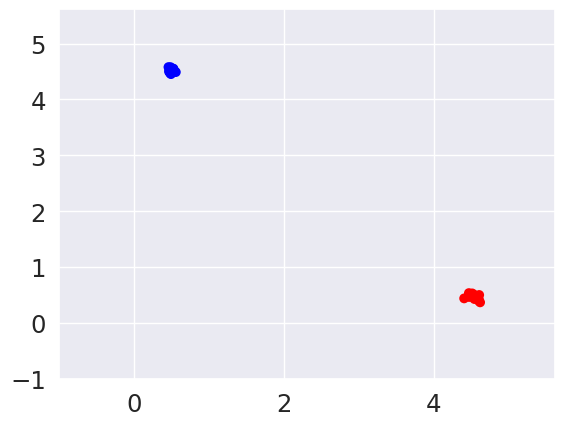

In [ ]:
Z_final = traj[-1]
R_final=Z_final[0:N]
C_final=Z_final[N:2*N,:]

C_data=C_final[:,0]
col =[]
for i in range(N):
  a=np.abs(C_data[i]+1)
  b=np.abs(C_data[i])
  c=np.abs(C_data[i]-1)
  true_col= min([a,b,c])
  if(true_col==a):
    col.append('red')
  if(true_col==b):
    col.append('green')
  if(true_col==c):
    col.append('blue')
plt.scatter(R_final[:,0], R_final[:,1], c = col, s = 50,linewidth = 0)
plt.xlim((-1,np.max(R_final[:,0]+1)))
plt.ylim((-1,np.max(R_final[:,0]+1)))

plt.show()

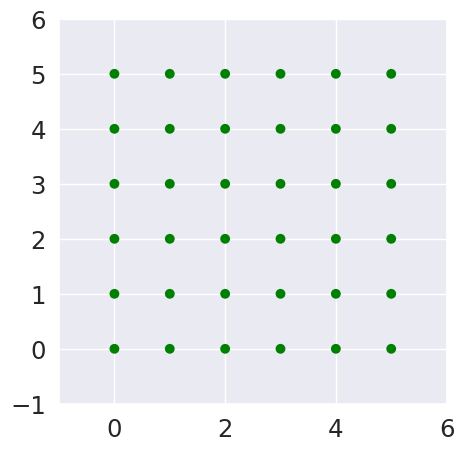

In [ ]:
state=traj
from matplotlib.animation import FuncAnimation, PillowWriter

# save as gif
fig_size = (5,5)
fig, ax = plt.subplots(figsize=fig_size)

def animate(k):
  j=int(len(traj)/200)*k
  #j=k
  ax.clear()
  col =[]
  Z_final = state[j]
  R_final=Z_final[0:N,:]
  C_final=Z_final[N:2*N,:]

  C_data=C_final[:,0]

  for i in range(N):
    a=np.abs(C_data[i]+1)
    b=np.abs(C_data[i])
    c=np.abs(C_data[i]-1)
    true_col= min([a,b,c])
    if(true_col==a):
      col.append('red')
    if true_col==b:
      col.append('green')
    if true_col==c:
      col.append('blue')
  #for i in range(N):
  plot=ax.scatter(R_final[:,0], R_final[:,1], c = col, s = 50,linewidth = 0)
  plt.xlim((-1,np.max(R_final[:,0]+1)))
  plt.ylim((-1,np.max(R_final[:,0]+1)))
  #plt.xlim((-1,3))
  #plt.ylim((-1,3))
  # plt.xticks([])
  # plt.yticks([])

  #plt.show()


    #return bgrnd,fgrnd
  return plot

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=200)
ani.save("st_new_stochastic.gif", dpi=300, writer=PillowWriter(fps=10))

In [ ]:
from tempfile import TemporaryFile
outfile = TemporaryFile()
np.savez(outfile, traj)

In [ ]:
np.save('traj_arr_new_36_particles', traj, allow_pickle=True)

In [ ]:
traj1=np.load('traj_arr_new_36_particles.npy', allow_pickle=True)

In [ ]:
cost=[37.075985189287955,35.57967868675055,34.820671596929316,34.10363881269762,33.22995744500597, 32.278500117822084,31.743994901070955,31.253307480591264
,30.648723466102883
, 30.046279963597247
, 29.504503667455033
, 28.972831752183836
, 28.516764022484736
, 28.238317509647516
, 27.887135564856667
, 27.51766206939733
, 27.176239521134303
, 26.957190893746702
, 26.6473385196835
, 26.38507973957403
, 26.084297611133675
, 25.81507798109313
, 25.542608201229342
, 25.319811631206722
, 25.157723457295365
, 24.999107371727604
, 24.845068711327112
, 24.69732201261858
, 24.49645718418977
, 24.35119571133261
, 24.212745707540165
, 24.07612705407415
, 23.939787282087774
, 23.810197678551564
, 23.680784641327968
, 23.54712581279632
, 23.418314265881083
, 23.29057608929081
, 23.166866447105594
, 23.012533375221402
, 22.889940031691058
, 22.714618696101432
, 22.540547512862254
, 22.430125377430635
, 22.324114962178896
, 22.217571152701808
, 22.109081605627416
, 21.96363873581673
, 21.861149405816704
, 21.76142042688073
, 21.661497486391497
, 21.56588359756147
, 21.471441505390224
, 21.37878680407534
, 21.239960263796206
, 21.158431685404807
, 21.078703007060923
, 20.99966871320566
, 20.88868618164376
, 20.785231336704634
, 20.685006002125114
, 20.60209700351755
, 20.541526194399285
, 20.485015078032774
,20.428798765381245
, 20.375579252779552
, 20.324277314456108
, 20.274476820660215
, 20.225609515996478
, 20.178322550156583
, 20.10962923162985
, 20.041379232047635
, 20.00009241176521
, 19.946222631973477
, 19.91015107359949
, 19.86118856819932
, 19.82464080041601
, 19.792342487234137
, 19.745992672355268
, 19.71259628558897
, 19.6670255348539
, 19.63568659055823
, 19.602738354549633
, 19.56011653335387
, 19.529152951160558
, 19.49795012366305
, 19.45642236487585
, 19.426001459225525
, 19.380654768312112
, 19.353555653544998
, 19.31364460136276
, 19.274971168530648
, 19.23122664719498
, 19.191266619898812
, 19.141015225806534
, 19.11325709363863
, 19.08218813416953
, 19.036030278990385
, 19.00691056603392
, 18.9649560468011
, 18.900714638462418
, 18.890043363645823
, 18.83164286657251
, 18.77568028208652
, 18.73905796011275
, 18.67906143886128
, 18.623103189597927
, 18.584212878510886
, 18.521989105677758
, 18.48662881403967
, 18.445025417892467
, 18.404933505228094
, 18.36426453180309
, 18.32720560011324
, 18.27743465010624
, 18.2395521523604
, 18.197158495944667
, 18.14455460192374
, 18.104787108280178
, 18.047521084563552
, 18.006688100815243
, 17.97036189375527
, 17.930407923887348
, 17.891447550711753
, 17.851155913923023
, 17.813001233842723
, 17.771191775204613
, 17.727243295216226
, 17.686698362145528
, 17.646515843374292
, 17.60741875855678
, 17.565261649163734
, 17.523585932819586
, 17.485965107757284
, 17.4199331481087
, 17.377417612750605
, 17.32138426410584
, 17.27652651708251
, 17.211408515309266
, 17.15348720391743
, 17.113655946732568
, 17.068778605891204
, 17.02706996637743
, 16.971219002703037
, 16.930476492723663
, 16.890076152919107
, 16.826906228571737
, 16.77522474375732
, 16.738170729833765
, 16.702377539014293
, 16.664647666919237
, 16.602003416184115
, 16.56332978089735
, 16.528523914978493
, 16.473449964559872
, 16.44048507684949
, 16.405787100612613
, 16.37738637836771
, 16.327946208046303
, 16.282321784855327
,16.25411039784537
, 16.21485463584522
, 16.177630459308745
, 16.132345147474215
, 16.09574540227755
, 16.071087754808445
, 16.03151981974957
, 15.991688692048335
, 15.960515398513339
, 15.929243946239227
, 15.89730568243175
, 15.858353745518093
, 15.835282986844742
, 15.81323264428729
, 15.792111024432918
, 15.761560574657107
, 15.740321647611829
, 15.706154620286886
, 15.676468880490209
, 15.658771071240343
, 15.62880536534103
, 15.610818564599795
, 15.581008182409917
, 15.552369505964386
, 15.53173800947205
, 15.511357468681746
, 15.490625794475264
, 15.470116112708471
, 15.446098236317097
, 15.427089876154092
, 15.392020951509082
, 15.372392734526178
, 15.353525258553264
, 15.3363140243878
, 15.318499695053886
, 15.295701612183317
, 15.277433604923946
, 15.25817682955356
, 15.236957059851273
, 15.218591770184803
, 15.17295994423912]

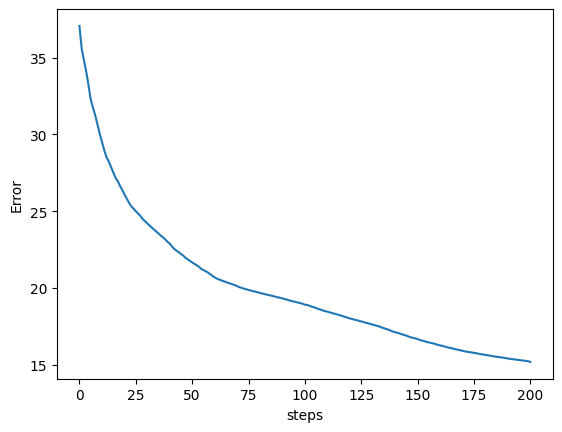

In [ ]:
plt.plot(cost)
plt.xlabel('steps')
plt.ylabel('Error')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('error.pdf',bbox_inches='tight')

In [ ]:
len(cost)

201

In [ ]:
ls

error.pdf                             traj_64_particles_counter1loop0.npy
traj_64_particles_counter0loop0.npy   traj_64_particles_counter1loop25.npy
traj_64_particles_counter0loop25.npy  traj_64_particles_counter1loop50.npy
traj_64_particles_counter0loop50.npy  traj_64_particles_counter1loop75.npy
traj_64_particles_counter0loop75.npy  traj_64_particles_counter2loop0.npy


In [ ]:
traj1=np.load('traj_64_particles_counter2loop0.npy')

In [ ]:
traj1[-1].shape

(128, 2)